# Modelo de Prospectividad Mineral con Machine Learning y Teledetección
### Proyecto de Exploración Digital - Franja Atacama, Chile

**Autor:** Pablo Toledo
**Fecha:** 04/12/2025

---

### 1. Resumen
Este notebook documenta el flujo de trabajo completo para la generación de un **Mapa de Prospectividad (Favorabilidad)** de depósitos tipo **IOCG** (Iron Oxide Copper Gold) en la Región de Atacama.

El modelo integra datos de teledetección espectral con cartografía geológica oficial mediante algoritmos de **Machine Learning Supervisado (Random Forest)**, logrando identificar nuevos blancos de exploración basándose en patrones de alteración hidrotermal y control estructural.

### 2. Fuentes de Datos (Input)
El modelo se alimenta de la fusión de datos raster y vectoriales:
* **Imágen Satelital:** Escena **ASTER L1T** (NASA/METI). Procesamiento de bandas SWIR (Infrarrojo de Onda Corta) para detección de arcillas y alteración.
* **Cartografía Geológica:** Base de datos **Sernageomin (1:100.000)**.
    * *Fallas:* Control estructural regional.
    * *Geología General:* Unidades litológicas y contactos intrusivos.
    * *Yacimientos:* Base de datos de minas conocidas (Entrenamiento).
* **Área de Estudio:** Aprox. **3.700 km²** (Cobertura de una escena ASTER estándar; 60x60km aprox). Coordenadas aprox: -28.58, -29.24 y -71.2, -70.4

### 3. Metodología y Flujo de Trabajo
El código se estructura en los siguientes bloques lógicos:

1.  **Pre-procesamiento:**
    * Lectura de archivos HDF (Hierarchical Data Format).
    * Generación de índices espectrales (Ratios de Banda) para resaltar alteración hidrotermal.
    * Corrección geométrica y alineación de sistemas de coordenadas (WGS84 / UTM).

2.  **Procesamiento de Variables:**
    Transformación de mapas geológicos en variables numéricas para el modelo:
    * **Proximidad Estructural (Fallas):** Lógica *Fuzzy* con radio de influencia de 500m.
    * **Proximidad a Contactos Intrusivos:** Lógica *Fuzzy* (Halo térmico) de 400m.
    * **Litología Favorable:** Filtro binario de rocas huéspedes competentes (Cretácico/Intrusivos).
    * **Alteración Espectral:** Intensidad de respuesta en bandas ASTER.

3.  **Modelamiento (Machine Learning):**
    * Algoritmo: **Random Forest**.
    * Estrategia: Balanceo de clases (1:10) para manejar la escasez de depósitos.
    * Optimización: *Hyperparameter Tuning* (Ajuste de hiperparámetros) para evitar overfitting.

4.  **Validación y Resultados:**
    * **Validación Cruzada Espacial (Spatial K-Fold):** Evaluación del modelo en "distritos desconocidos" (AUC ~0.75).
    * **Ground Truthing:** Verificación visual de coincidencia con minas históricas.
    * **Producto Final:** GeoTIFF exportable con probabilidad de mineralización (0-1).

---
Referencias:

* Shapes: Tienda Sernageomin; Geología del área Vallenar-Domeyko. Región de Atacama. 2009. Escala 1:100.000. https://tiendadigital.sernageomin.cl/es/geologia-basica/996-2009-geologia-del-area-vallenar-domeyko-region-de-atacama-escala-1-100000.html

* hdf : Desde la pagina https://search.earthdata.nasa.gov/; AST_L1T_00308302006145545_20150515232237_38182.hdf

* Se utilizaron asistentes de IA para acelerar la escritura de código Python, permitiendo enfocar el esfuerzo en el análisis de datos, la interpretación geológica y la validación.

**Nota: Este proyecto es un Ejercicio Conceptual diseñado para demostrar un flujo de trabajo.

Los parámetros geológicos utilizados (radios de influencia fuzzy, pesos de variables) son estimaciones teóricas aplicadas con fines demostrativos. Un modelo de exploración requeriría una calibración más rigurosa de estos parámetros basada por ejemplo en: Conocimiento experto del distrito específico, validación de campo detallada y datos geoquímicos complementarios o cualquier otro estudio. ---> Por lo que si bien esta hecho con datos reales, le falta maduración.

In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

# MONTAR DRIVE (Para acceder a tu archivo descargado)
drive.mount('/content/drive')

# Ruta
file_path = '/content/drive/MyDrive/Proyectoprospectivo/Data/raster/AST_L1T_00308302006145545_20150515232237_38182.hdf'

# LEER BANDAS ASTER
# Los HDF de ASTER tienen subdatasets. Necesitamos las bandas SWIR (4 a 9)
# Usualmente están en el subdataset de resolución 30m

def leer_banda_aster(path, band_name):
    """Función auxiliar para extraer una banda específica del HDF"""
    # Nota: ASTER HDF es complejo. Usaremos rasterio para listar los subdatasets
    with rasterio.open(path) as src:
        subdatasets = src.subdatasets
        # Buscar el subdataset que corresponde a las bandas SWIR (VNIR es 15m, SWIR es 30m)
        # Esto puede variar según la versión del producto, así que listamos primero
        for sub in subdatasets:
            print(f"Subdataset encontrado: {sub}")

    # SI ESTO FALLA O ES MUY COMPLEJO; LÓGICA MÁS DIRECTA ABAJO

print("Explorando estructura del HDF...")
try:
    with rasterio.open(file_path) as src:
        print(f"Driver: {src.driver}")
        print(f"Cantidad de Subdatasets: {len(src.subdatasets)}")
        # Imprimimos los primeros 5 para ver qué hay
        for i, name in enumerate(src.subdatasets[:5]):
            print(f"{i}: {name}")

except Exception as e:
    print(f"Error al abrir: {e}")
    print("Asegúrate de que la ruta del archivo sea correcta.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Explorando estructura del HDF...
Error al abrir: '/content/drive/MyDrive/Proyectoprospectivo/Data/raster/AST_L1T_00308302006145545_20150515232237_38182.hdf' not recognized as being in a supported file format.
Asegúrate de que la ruta del archivo sea correcta.


Leeyendo bandas SWIR desde el HDF...
Bandas cargadas. Dimensiones: (2443, 2773)


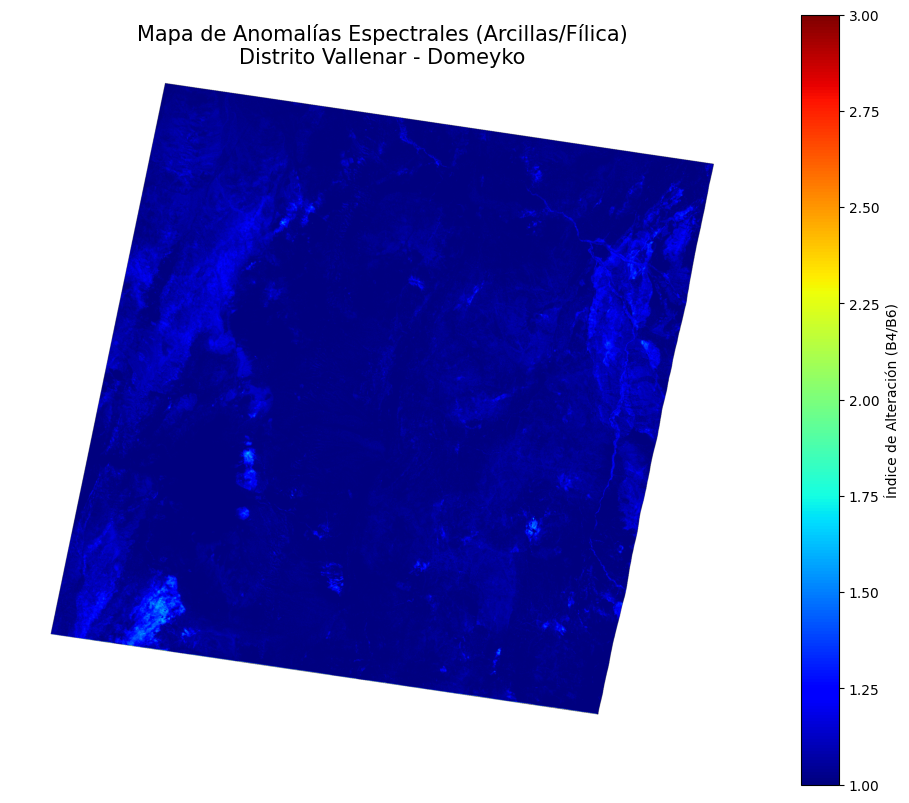

INTERPRETACIÓN:
 Azul/Verde: Roca fresca o suelo sin alteración.
 Amarillo/Naranja: Alteración moderada.
 ROJO: Anomalía Fuerte (Posible blanco de exploración).


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal

# Ruta
file_path = '/content/drive/MyDrive/Proyectoprospectivo/Data/raster/AST_L1T_00308302006145545_20150515232237_38182.hdf'

# CONSTRUIR RUTAS A LAS BANDAS (La sintaxis HDF4 es delicada)
# GDAL necesita este formato exacto: HDF4_EOS:EOS_SWATH:"RUTAL_AL_ARCHIVO":GRUPO:BANDA
path_b4 = f'HDF4_EOS:EOS_SWATH:"{file_path}":SWIR_Swath:ImageData4'
path_b6 = f'HDF4_EOS:EOS_SWATH:"{file_path}":SWIR_Swath:ImageData6'

print("Leeyendo bandas SWIR desde el HDF...")

# CARGAR DATOS A MEMORIA
try:
    # Abrir Banda 4
    ds_4 = gdal.Open(path_b4)
    band4 = ds_4.ReadAsArray().astype(float)

    # Abrir Banda 6
    ds_6 = gdal.Open(path_b6)
    band6 = ds_6.ReadAsArray().astype(float)

    print(f"Bandas cargadas. Dimensiones: {band4.shape}")

    # CORRECCIÓN DE DATOS (Limpieza)
    # Los bordes negros suelen ser 0. Los convertimos a NaN para que no molesten en el cálculo.
    band4[band4 == 0] = np.nan
    band6[band6 == 0] = np.nan

    # CÁLCULO DEL ÍNDICE DE ALTERACIÓN (Mineral Mapping)
    # Fórmula: B4 / B6 (Resalta Al-OH: Caolinita, Sericita)
    # Sumamos un epsilon (0.0001) para evitar división por cero si queda algún 0
    alteration_ratio = band4 / (band6 + 0.0001)

    # VISUALIZACIÓN
    plt.figure(figsize=(12, 10))

    # Usamos un mapa de colores "jet" o "nipy_spectral" para resaltar anomalías
    # vmin y vmax controlan el contraste. Un ratio > 2.0 suele ser anomalía fuerte.
    img = plt.imshow(alteration_ratio, cmap='jet', vmin=1.0, vmax=3.0)

    plt.colorbar(img, label='Índice de Alteración (B4/B6)')
    plt.title("Mapa de Anomalías Espectrales (Arcillas/Fílica)\nDistrito Vallenar - Domeyko", fontsize=15)
    plt.axis('off') # Quitar ejes de coordenadas de píxeles
    plt.show()

    print("INTERPRETACIÓN:")
    print(" Azul/Verde: Roca fresca o suelo sin alteración.")
    print(" Amarillo/Naranja: Alteración moderada.")
    print(" ROJO: Anomalía Fuerte (Posible blanco de exploración).")

except Exception as e:
    print(f" Error durante el procesamiento: {e}")

--- ESTADÍSTICAS REALES ---
Mínimo valor: 0.2773
Máximo valor: 12.4994
Promedio: 1.0244
Rango óptimo sugerido: 0.9306 a 1.1956


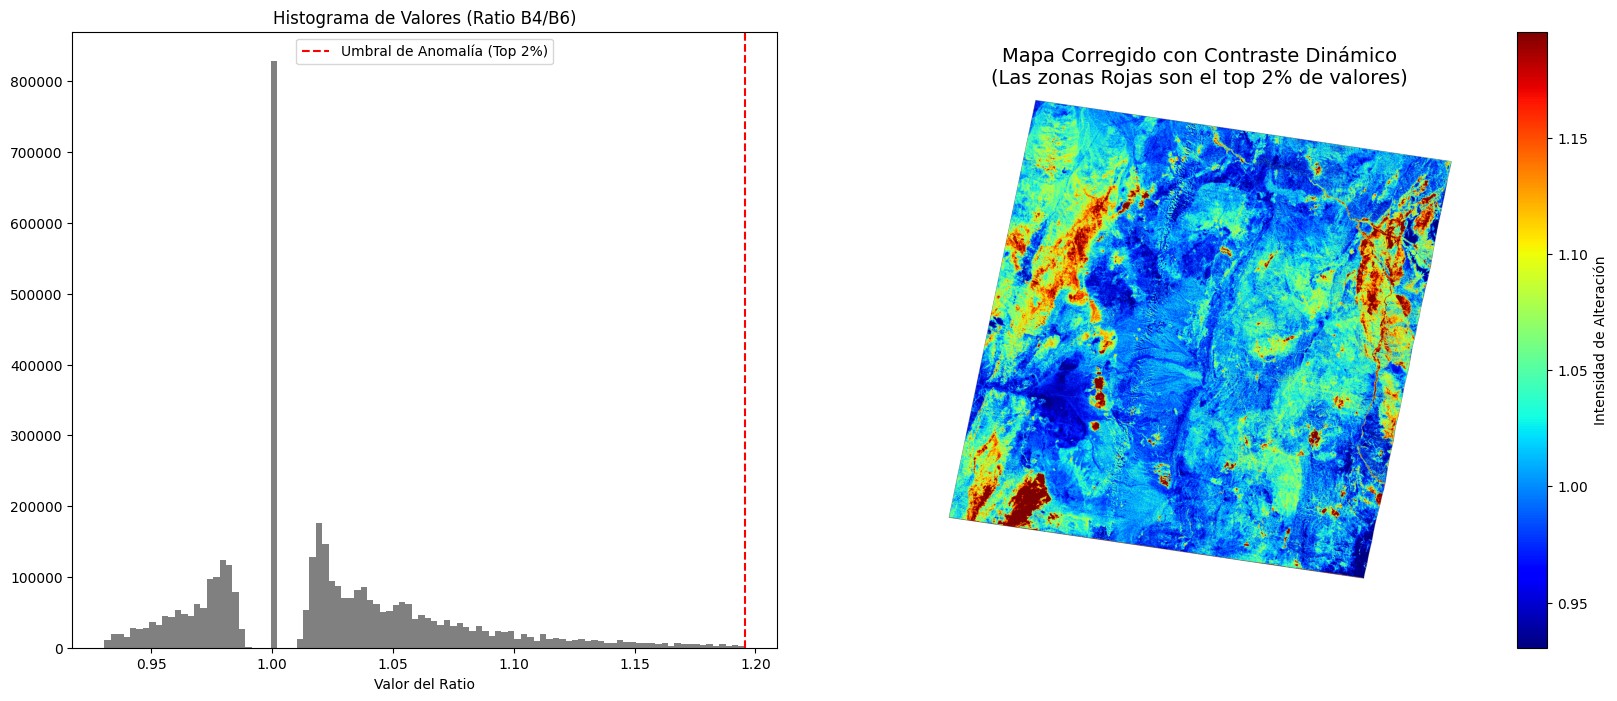

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# ESTADÍSTICA DE LOS DATOS
# Aplanamos el array y quitamos los NaN para ver los números
datos_validos = alteration_ratio[~np.isnan(alteration_ratio)]

print(f"--- ESTADÍSTICAS REALES ---")
print(f"Mínimo valor: {np.min(datos_validos):.4f}")
print(f"Máximo valor: {np.max(datos_validos):.4f}")
print(f"Promedio: {np.mean(datos_validos):.4f}")

# Calculamos los percentiles para el contraste automático
p2 = np.percentile(datos_validos, 2)  # El piso (fondo)
p98 = np.percentile(datos_validos, 98) # El techo (anomalías fuertes)
print(f"Rango óptimo sugerido: {p2:.4f} a {p98:.4f}")

# VISUALIZACIÓN DIAGNÓSTICA
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Gráfico A: Histograma
ax1.hist(datos_validos, bins=100, color='gray', range=(p2, p98))
ax1.axvline(p98, color='red', linestyle='--', label='Umbral de Anomalía (Top 2%)')
ax1.set_title("Histograma de Valores (Ratio B4/B6)")
ax1.set_xlabel("Valor del Ratio")
ax1.legend()

# Gráfico B: Mapa con Auto-Stretch
# Usamos p2 y p98 como vmin y vmax para forzar el contraste
im = ax2.imshow(alteration_ratio, cmap='jet', vmin=p2, vmax=p98)
plt.colorbar(im, ax=ax2, label='Intensidad de Alteración')
ax2.set_title("Mapa Corregido con Contraste Dinámico\n(Las zonas Rojas son el top 2% de valores)", fontsize=14)
ax2.axis('off')

plt.show()

In [ ]:
import os
import numpy as np
from osgeo import gdal, osr

# Rutas
input_hdf = '/content/drive/MyDrive/Proyectoprospectivo/Data/raster/AST_L1T_00308302006145545_20150515232237_38182.hdf'
output_folder = '/content/drive/MyDrive/Proyectoprospectivo/Data/raster/'
output_filename = 'Mapa_Alteracion_FINAL_Coloreado.tif'
final_path = os.path.join(output_folder, output_filename)

print("Iniciando procesamiento...")

# PREPARACIÓN: EXTRAER Y REPROYECTAR BANDAS
# Usamos gdal.Warp para sacar las bandas del HDF y pasarlas a WGS84 (Lat/Lon) automáticamente.

path_b4_hdf = f'HDF4_EOS:EOS_SWATH:"{input_hdf}":SWIR_Swath:ImageData4'
path_b6_hdf = f'HDF4_EOS:EOS_SWATH:"{input_hdf}":SWIR_Swath:ImageData6'

print("1. Georreferenciando bandas crudas (Warping)...")
# Creamos archivos temporales en memoria ('/vsimem/') para no llenar Drive
warp_options = gdal.WarpOptions(dstSRS='EPSG:4326', format='GTiff') # EPSG:4326 es Lat/Lon (Google Earth)

ds_b4_warped = gdal.Warp('/vsimem/b4_temp.tif', path_b4_hdf, options=warp_options)
ds_b6_warped = gdal.Warp('/vsimem/b6_temp.tif', path_b6_hdf, options=warp_options)

# MATEMÁTICA DE BANDAS
print("2. Calculando índice espectral...")
b4 = ds_b4_warped.GetRasterBand(1).ReadAsArray().astype(float)
b6 = ds_b6_warped.GetRasterBand(1).ReadAsArray().astype(float)

# Limpieza (NaNs)
b4[b4 == 0] = np.nan
b6[b6 == 0] = np.nan

# Ratio
ratio = b4 / (b6 + 0.00001)

# COLOREADO
print("3. Aplicando mapa de colores (Renderizando)...")

# Normalizamos los datos para que el color quede bonito (Percentil 2% a 98%)
vmin, vmax = np.nanpercentile(ratio, [2, 98])
# Escalar datos de 0 a 255 (Byte)
ratio_scaled = (ratio - vmin) / (vmax - vmin) * 255
ratio_scaled[ratio_scaled < 0] = 0
ratio_scaled[ratio_scaled > 255] = 255
ratio_byte = np.nan_to_num(ratio_scaled).astype(np.uint8)

# Crear máscara de transparencia (para que lo negro sea transparente)
alpha_mask = np.where(np.isnan(ratio), 0, 255).astype(np.uint8)

# GUARDAR EL ARCHIVO FINAL (RGBA)
rows, cols = ratio.shape
driver = gdal.GetDriverByName('GTiff')
out_ds = driver.Create(final_path, cols, rows, 2, gdal.GDT_Byte) # 2 bandas: Gris + Alpha

# Copiar la georreferencia CORRECTA del archivo Warped
out_ds.SetGeoTransform(ds_b4_warped.GetGeoTransform())
out_ds.SetProjection(ds_b4_warped.GetProjection())

# Escribir datos
out_ds.GetRasterBand(1).WriteArray(ratio_byte) # La imagen
out_ds.GetRasterBand(2).WriteArray(alpha_mask) # La transparencia

# Asignar un mapa de colores (Paleta falsa: Negro -> Rojo)
# Truco: Creamos una rampa de color simple
color_table = gdal.ColorTable()
for i in range(256):
    # Generar gradiente Azul a Rojo (Estilo 'Jet' simplificado)
    # i=0 (Fondo) -> i=255 (Anomalía)
    if i < 128: # Bajos valores (Azul/Verde)
        color_table.SetColorEntry(i, (0, i*2, 255-i*2, 255))
    else:       # Altos valores (Amarillo/Rojo)
        color_table.SetColorEntry(i, (255, 255-(i-128)*2, 0, 255))

out_ds.GetRasterBand(1).SetColorTable(color_table)

out_ds.FlushCache()
out_ds = None # Cerrar archivo

print(f"Archivo guardado en: {final_path}")

Iniciando procesamiento...
1. Georreferenciando bandas crudas (Warping)...
2. Calculando índice espectral...
3. Aplicando mapa de colores (Renderizando)...
Archivo guardado en: /content/drive/MyDrive/Proyectoprospectivo/Data/raster/Mapa_Alteracion_FINAL_Coloreado.tif


Construyendo Dataset para Machine Learning...
Variable ASTER cargada: 6832678 píxeles.
Data mapa aster lista


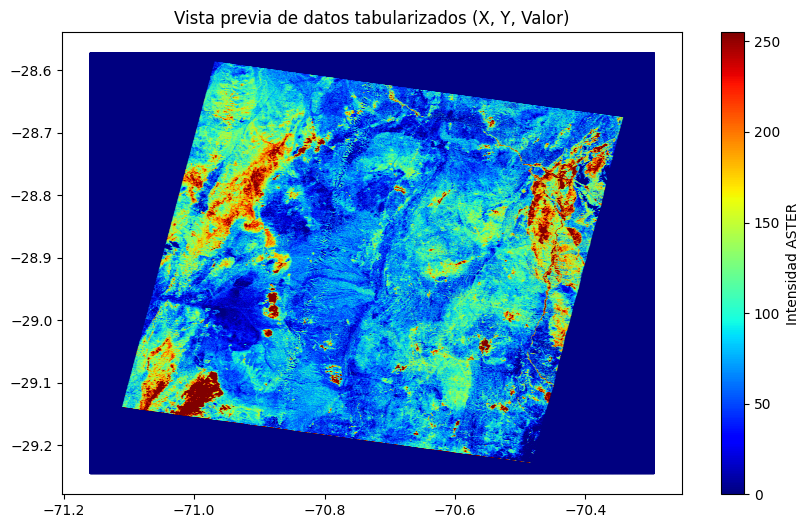

In [8]:
import rasterio
import numpy as np
import pandas as pd
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt

# Ruta tif
tif_path = '/content/drive/MyDrive/Proyectoprospectivo/Data/raster/Mapa_Alteracion_FINAL_Coloreado.tif'

print("Construyendo Dataset para Machine Learning...")

# CARGAR LA VARIABLE REAL (ASTER ALTERATION)
with rasterio.open(tif_path) as src:
    # Leemos la Banda 1 (que tiene los valores del ratio coloreados o crudos)
    ###Nota: Si guardamos coloreado (0-255), usaremos eso como proxy de intensidad.
    # Idealmente usaríamos el ratio crudo (float), pero el coloreado sirve para la demo.
    alteration_data = src.read(1)

    # Metadatos para saber el tamaño real en el mundo
    transform = src.transform
    height, width = alteration_data.shape

    # Generar coordenadas X, Y reales para cada píxel
    cols, rows = np.meshgrid(np.arange(width), np.arange(height))
    xs, ys = rasterio.transform.xy(transform, rows, cols)

    # Aplanar todo (Convertir matriz 2D a lista 1D)
    x_flat = np.array(xs).flatten()
    y_flat = np.array(ys).flatten()
    alteration_flat = alteration_data.flatten()

print(f"Variable ASTER cargada: {len(alteration_flat)} píxeles.")

# Crear el DataFrame df_dataset antes de usarlo
df_dataset = pd.DataFrame({
    'Este_UTM': x_flat,
    'Norte_UTM': y_flat,
    'ASTER_Alteration': alteration_flat
})

print(f"Data mapa aster lista")

# 4. VISUALIZACIÓN RÁPIDA DE LA DATA
plt.figure(figsize=(10, 6))
plt.scatter(df_dataset['Este_UTM'], df_dataset['Norte_UTM'],
            c=df_dataset['ASTER_Alteration'], cmap='jet', s=0.1)
plt.colorbar(label='Intensidad ASTER')
plt.title("Vista previa de datos tabularizados (X, Y, Valor)")
plt.show()

Inspeccionando la carpeta: /content/drive/MyDrive/Proyectoprospectivo/Data/GEOL/

 Encontrados 17 Shapefiles: ['GB_ALTERACION_L.shp', 'GB_ESTRUCTURA.shp', 'GB_CONTACTO_L.shp', 'GB_ALTERACION_P.shp', 'GB_INT_ASS_EST_L.shp', 'GB_METAMORFISMO_P.shp', 'GB_METAMORFISMO_L.shp', 'GB_FALLA_L.shp', 'GB_GEOMORFOLOGIA.shp', 'GB_GEOMORFOLOGIA_L.shp', 'GB_PLIEGUE_L.shp', 'GB_UNIDAD_GEO_P.shp', 'GB_GEOCRONOLOGIA.shp', 'PERFIL_L.shp', 'GB_FOSIL.shp', 'APORTE.shp', 'RMM_YACIMIENTO.shp']

 ANALIZANDO: GB_ALTERACION_L.shp
 CRS (Sistema de Coordenadas): EPSG:31994
 Error al leer GB_ALTERACION_L.shp: index 0 is out of bounds for axis 0 with size 0
 ANALIZANDO: GB_ESTRUCTURA.shp
 CRS (Sistema de Coordenadas): EPSG:31994
 Tipo de Geometría: Point (Total elementos: 362)
 Columnas disponibles: ['CD_CORRELA', 'ESCALA', 'AZIMUTH', 'BUZAMIENTO', 'MANTEO', 'RAKE', 'UTM_ESTE', 'UTM_NORTE', 'OBSERVACIO', 'd_DIR_BUZA', 'd_DIR_MANT', 'd_TIPO', 'd_PROYECCI', 'geometry']

--- Primeras 3 filas de datos ---
  CD_CORRELA 

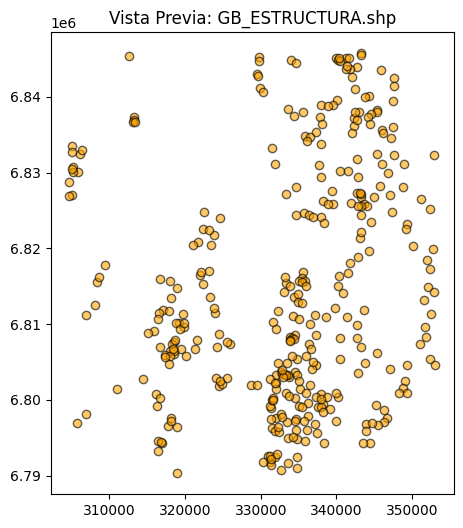



 ANALIZANDO: GB_CONTACTO_L.shp
 CRS (Sistema de Coordenadas): EPSG:31994
 Tipo de Geometría: LineString (Total elementos: 2452)
 Columnas disponibles: ['CD_CORRELA', 'ESCALA', 'SUBTIPO_DE', 'OBSERVACIO', 'd_TP_INFOR', 'geometry']

--- Primeras 3 filas de datos ---
  CD_CORRELA  ESCALA               SUBTIPO_DE OBSERVACIO d_TP_INFOR
0       M164  100000  Contacto Estratigrafico       None  Observada
1       M164  100000  Contacto Estratigrafico       None  Observada
2       M164  100000       Contacto Intrusivo       None  Observada


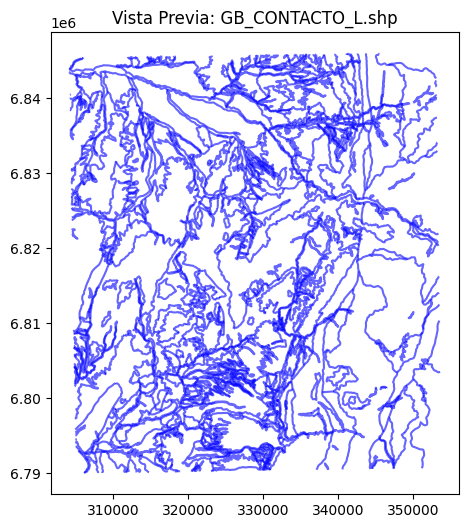



 ANALIZANDO: GB_ALTERACION_P.shp
 CRS (Sistema de Coordenadas): EPSG:31994
 Tipo de Geometría: Polygon (Total elementos: 41)
 Columnas disponibles: ['CD_CORRELA', 'ALTERACION', 'ESCALA', 'NOMBRE', 'CODIGO', 'OBSERVACIO', 'geometry']

--- Primeras 3 filas de datos ---
  CD_CORRELA ALTERACION  ESCALA NOMBRE CODIGO OBSERVACIO
0       M164     Fílica  100000   None   None       None
1       M164     Fílica  100000   None   None       None
2       M164     Fílica  100000   None   None       None


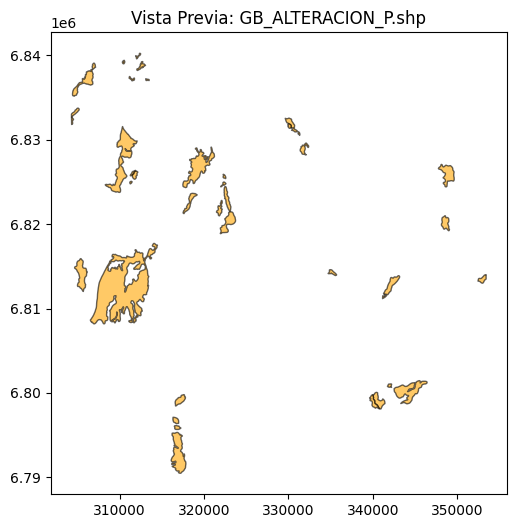



 ANALIZANDO: GB_INT_ASS_EST_L.shp
 CRS (Sistema de Coordenadas): EPSG:31994
 Tipo de Geometría: LineString (Total elementos: 328)
 Columnas disponibles: ['CD_CORRELA', 'ESCALA', 'CODIGO', 'OBSERVACIO', 'd_LITOLOGI', 'd_TIPO_INT', 'd_PROYECCI', 'geometry']

--- Primeras 3 filas de datos ---
  CD_CORRELA  ESCALA CODIGO              OBSERVACIO d_LITOLOGI d_TIPO_INT  \
0       M164  100000   None  Diques indiferenciados       None      Dique   
1       M164  100000   None  Diques indiferenciados       None      Dique   
2       M164  100000   None  Diques indiferenciados       None      Dique   

       d_PROYECCI  
0  SIRGAS UTM 19S  
1  SIRGAS UTM 19S  
2  SIRGAS UTM 19S  


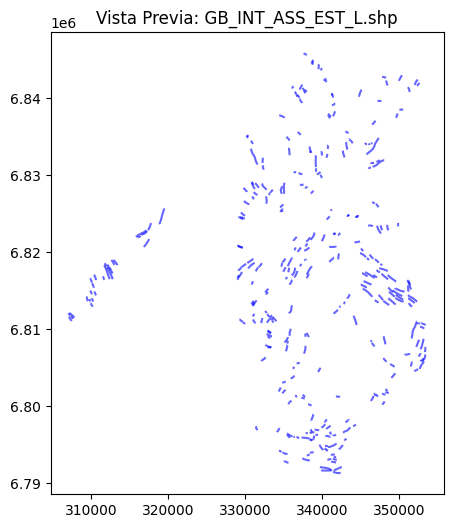



 ANALIZANDO: GB_METAMORFISMO_P.shp
 CRS (Sistema de Coordenadas): EPSG:31994
 Tipo de Geometría: Polygon (Total elementos: 23)
 Columnas disponibles: ['CD_CORRELA', 'ESCALA', 'CODIGO', 'OBSERVACIO', 'd_METAMORF', 'd_PROYECCI', 'geometry']

--- Primeras 3 filas de datos ---
  CD_CORRELA  ESCALA CODIGO OBSERVACIO         d_METAMORF      d_PROYECCI
0       M164  100000   None       None  Zona de milonitas  SIRGAS UTM 19S
1       M164  100000   None       None  Zona de milonitas  SIRGAS UTM 19S
2       M164  100000   None       None  Zona de milonitas  SIRGAS UTM 19S


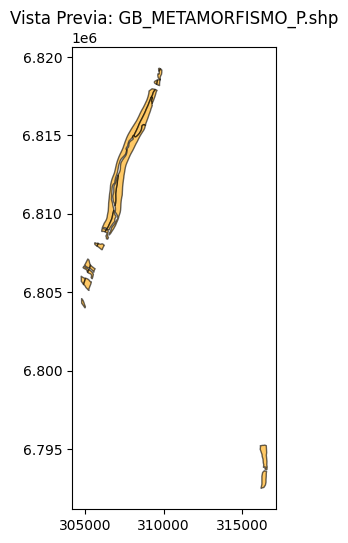



 ANALIZANDO: GB_METAMORFISMO_L.shp
 CRS (Sistema de Coordenadas): EPSG:31994
 Error al leer GB_METAMORFISMO_L.shp: index 0 is out of bounds for axis 0 with size 0
 ANALIZANDO: GB_FALLA_L.shp
 CRS (Sistema de Coordenadas): EPSG:31994
 Tipo de Geometría: LineString (Total elementos: 394)
 Columnas disponibles: ['CD_CORRELA', 'ESCALA', 'SUBTIPO_DE', 'NOMBRE', 'OBSERVACIO', 'd_SUBTIPO', 'd_NOMBRE', 'd_DIR_MANT', 'd_FALLA', 'd_TP_INFOR', 'd_PROYECCI', 'geometry']

--- Primeras 3 filas de datos ---
  CD_CORRELA  ESCALA     SUBTIPO_DE NOMBRE OBSERVACIO      d_SUBTIPO d_NOMBRE  \
0       M164  100000  Falla Inversa   None       None  Falla Inversa     None   
1       M164  100000  Falla Inversa   None       None  Falla Inversa     None   
2       M164  100000  Falla Inversa   None       None  Falla Inversa     None   

         d_DIR_MANT        d_FALLA d_TP_INFOR      d_PROYECCI  
0  Hacia el SurEste  Falla inversa  Observada  SIRGAS UTM 19S  
1  Hacia el SurEste  Falla inversa  Observada  

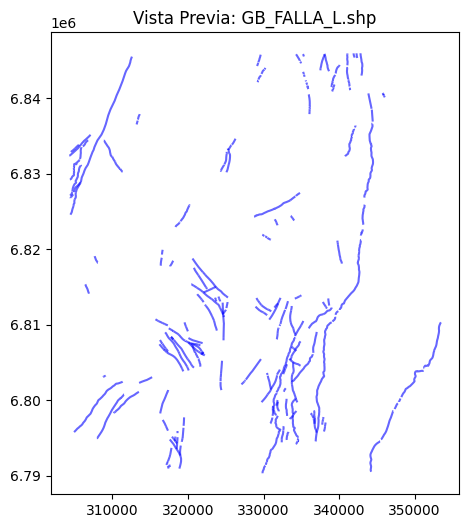



 ANALIZANDO: GB_GEOMORFOLOGIA.shp
 CRS (Sistema de Coordenadas): EPSG:31994
 Error al leer GB_GEOMORFOLOGIA.shp: index 0 is out of bounds for axis 0 with size 0
 ANALIZANDO: GB_GEOMORFOLOGIA_L.shp
 CRS (Sistema de Coordenadas): EPSG:31994
 Tipo de Geometría: LineString (Total elementos: 70)
 Columnas disponibles: ['CD_CORRELA', 'ESCALA', 'SUBTIPO_DE', 'OBSERVACIO', 'd_SUBTIPO', 'd_TP_INFOR', 'd_PROYECCI', 'd_GEOMORFO', 'geometry']

--- Primeras 3 filas de datos ---
  CD_CORRELA  ESCALA     SUBTIPO_DE OBSERVACIO      d_SUBTIPO d_TP_INFOR  \
0       M164  100000  Geomorfologia       None  Geomorfologia       None   
1       M164  100000  Geomorfologia       None  Geomorfologia       None   
2       M164  100000  Geomorfologia       None  Geomorfologia       None   

       d_PROYECCI d_GEOMORFO  
0  SIRGAS UTM 19S    Escarpe  
1  SIRGAS UTM 19S    Escarpe  
2  SIRGAS UTM 19S    Escarpe  


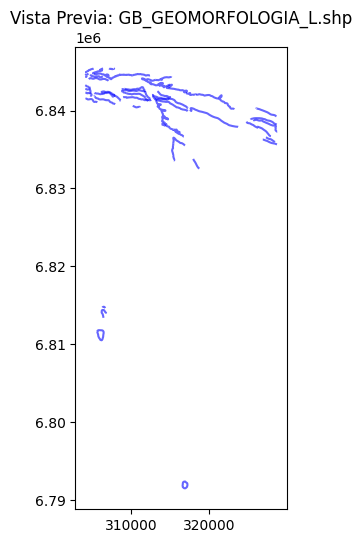



 ANALIZANDO: GB_PLIEGUE_L.shp
 CRS (Sistema de Coordenadas): EPSG:31994
 Tipo de Geometría: LineString (Total elementos: 47)
 Columnas disponibles: ['CD_CORRELA', 'ESCALA', 'SUBTIPO_DE', 'OBSERVACIO', 'NOMBRE', 'd_SUBTIPO', 'd_PROYECCI', 'd_TP_INFOR', 'd_TIPO_PLI', 'geometry']

--- Primeras 3 filas de datos ---
  CD_CORRELA  ESCALA          SUBTIPO_DE OBSERVACIO NOMBRE  \
0       M164  100000  Pliegue anticlinal       None   None   
1       M164  100000  Pliegue anticlinal       None   None   
2       M164  100000  Pliegue anticlinal       None   None   

            d_SUBTIPO      d_PROYECCI d_TP_INFOR  \
0  Pliegue anticlinal  SIRGAS UTM 19S  Observada   
1  Pliegue anticlinal  SIRGAS UTM 19S  Observada   
2  Pliegue anticlinal  SIRGAS UTM 19S  Observada   

                           d_TIPO_PLI  
0  Traza de plano axial de anticlinal  
1  Traza de plano axial de anticlinal  
2  Traza de plano axial de anticlinal  


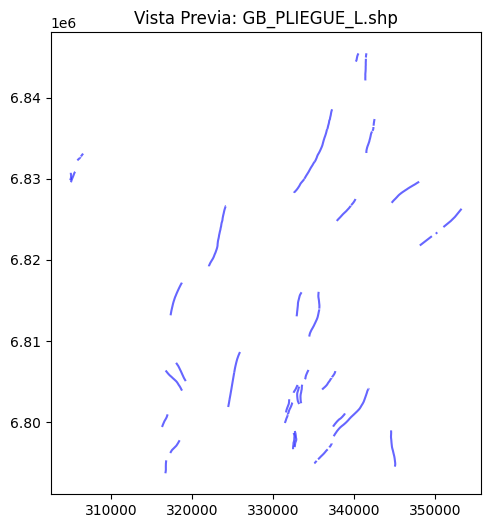



 ANALIZANDO: GB_UNIDAD_GEO_P.shp
 CRS (Sistema de Coordenadas): EPSG:31994
 Tipo de Geometría: Polygon (Total elementos: 789)
 Columnas disponibles: ['CD_CORRELA', 'ESCALA', 'SUBTIPO_DE', 'CODIGO', 'DEFINICION', 'GEOCHRON_A', 'GEOCHRON_1', 'NOMBRE', 'NOTA', 'UNIDAD_GEN', 'ERROR_MAX', 'ERROR_MIN', 'd_SUBTIPO', 'd_EDAD_EST', 'd_EDAD_E_1', 'd_EPOCA_ES', 'd_EPOCA__1', 'd_EVENTO', 'd_PERIODO_', 'd_PERIODO1', 'd_PROCESO', 'd_PROYECCI', 'd_UNIDAD', 'd_UNIDAD_G', 'd_AMBIENTE', 'd_TP_MEDID', 'geometry']

--- Primeras 3 filas de datos ---
  CD_CORRELA  ESCALA             SUBTIPO_DE  CODIGO DEFINICION GEOCHRON_A  \
0       M164  100000  AMBIENTE SEDIMENTARIO     Kc1       None       None   
1       M164  100000  AMBIENTE SEDIMENTARIO  JKpc3a       None       None   
2       M164  100000  AMBIENTE SEDIMENTARIO   PlHa2       None       None   

  GEOCHRON_1                                             NOMBRE  \
0       None  Formación Cerrillos. (1) Paraconglomerados y a...   
1       None  Formac

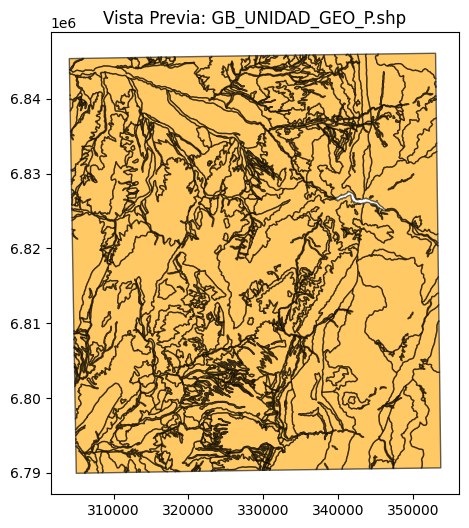



 ANALIZANDO: GB_GEOCRONOLOGIA.shp
 CRS (Sistema de Coordenadas): EPSG:31994
 Tipo de Geometría: Point (Total elementos: 94)
 Columnas disponibles: ['CD_CORRELA', 'ESCALA', 'SUBTIPO_DE', 'EDAD', 'ERROR', 'NOMBRE_MUE', 'UTM_ESTE', 'UTM_NORTE', 'REFERENCIA', 'URL_CERTIF', 'OBSERVACIO', 'd_SUBTIPO', 'd_TIPO_MUE', 'd_UNIDAD_M', 'd_MATERIAL', 'd_PROYECCI', 'geometry']

--- Primeras 3 filas de datos ---
  CD_CORRELA  ESCALA              SUBTIPO_DE  EDAD  ERROR NOMBRE_MUE  \
0       M164  100000  Potasio - Argon (K-Ar)  72.0    2.0        193   
1       M164  100000  Potasio - Argon (K-Ar)  98.0    4.0        196   
2       M164  100000  Potasio - Argon (K-Ar)  91.0    2.0        208   

      UTM_ESTE     UTM_NORTE    REFERENCIA URL_CERTIF  \
0  351469.5924  6.840475e+06  Este trabajo       None   
1  340147.6175  6.837442e+06  Este trabajo       None   
2  341482.6404  6.822097e+06  Este trabajo       None   

                           OBSERVACIO               d_SUBTIPO d_TIPO_MUE  \
0  m

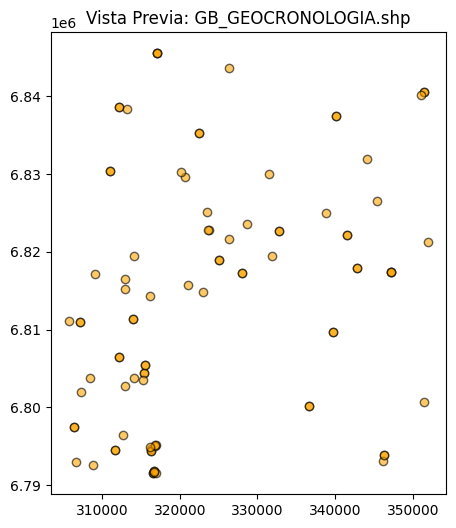



 ANALIZANDO: PERFIL_L.shp
 CRS (Sistema de Coordenadas): EPSG:31994
 Tipo de Geometría: LineString (Total elementos: 1)
 Columnas disponibles: ['CD_CORRELA', 'ESCALA', 'NOMBRE', 'IMAGEN', 'd_PROYECCI', 'geometry']

--- Primeras 3 filas de datos ---
  CD_CORRELA  ESCALA NOMBRE IMAGEN      d_PROYECCI
0       M164  100000    AA'   None  SIRGAS UTM 19S


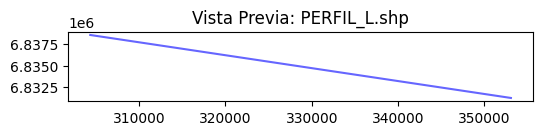



 ANALIZANDO: GB_FOSIL.shp
 CRS (Sistema de Coordenadas): EPSG:31994
 Tipo de Geometría: Point (Total elementos: 39)
 Columnas disponibles: ['CD_CORRELA', 'ESCALA', 'SUBTIPO_DE', 'LOCALIDAD', 'N_LOCALIDA', 'NOMBRE_MUE', 'REFERENCIA', 'UTM_ESTE', 'UTM_NORTE', 'URL_INFORM', 'UNIDADGENE', 'OBSERVACIO', 'ESPECIE', 'd_SUBTIPO', 'd_EDAD', 'd_EPOCA', 'd_UNIDADGE', 'd_MUESTRA', 'd_PROYECCI', 'd_EDAD_MAX', 'd_EPOCA_MA', 'geometry']

--- Primeras 3 filas de datos ---
  CD_CORRELA  ESCALA SUBTIPO_DE LOCALIDAD  N_LOCALIDA NOMBRE_MUE  \
0       M164  100000      FAUNA      None           0      MV-05   
1       M164  100000      FAUNA      None           0   AV-766\n   
2       M164  100000      FAUNA      None           0   AV-770\n   

                 REFERENCIA     UTM_ESTE     UTM_NORTE URL_INFORM  ...  \
0  Mourgues in este trabajo  338835.6392  6.825811e+06       None  ...   
1  Mourgues in este trabajo  325766.1537  6.803276e+06       None  ...   
2  Mourgues in este trabajo  324460.8267  

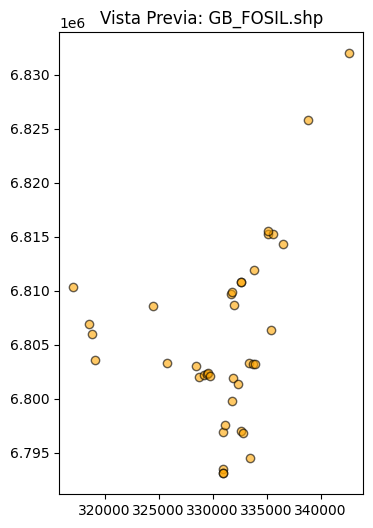



 ANALIZANDO: APORTE.shp
 CRS (Sistema de Coordenadas): EPSG:31994
 Error al leer APORTE.shp: index 0 is out of bounds for axis 0 with size 0
 ANALIZANDO: RMM_YACIMIENTO.shp
 CRS (Sistema de Coordenadas): EPSG:31994
 Tipo de Geometría: Point (Total elementos: 103)
 Columnas disponibles: ['CD_CORRELA', 'ESCALA', 'ID_YACIMIE', 'NOMBRE', 'TIPO_YACIM', 'TAMANO_YAC', 'MODELO_YAC', 'FORMA', 'DISTRITO', 'ASS_MENA', 'MINERALES_', 'MINERALES1', 'MINERALE_1', 'UTM_ESTE', 'UTM_NORTE', 'ESTADO', 'OBSERVACIO', 'UNIDAD_GEO', 'AZIMUTH', 'MANTEO', 'd_TIPO_YAC', 'd_MODELO_Y', 'd_FORMA', 'd_ASS_MENA', 'd_PROYECCI', 'd_UNIDAD_G', 'geometry']

--- Primeras 3 filas de datos ---
  CD_CORRELA  ESCALA  ID_YACIMIE       NOMBRE TIPO_YACIM TAMANO_YAC  \
0       M164  100000           1   Dos Amigos   T-YAC-22       None   
1       M164  100000           2  Dos Amigos?   T-YAC-22       None   
2       M164  100000           3       Volcàn   T-YAC-22       None   

  MODELO_YAC     FORMA  DISTRITO   ASS_MENA  ...

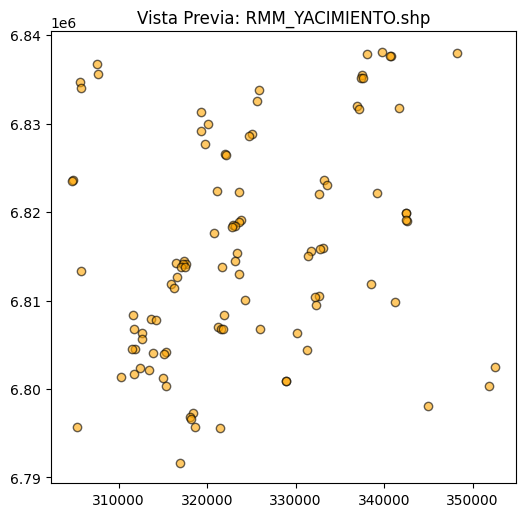

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import os

# Ruta shapes geol
shapefile_folder = '/content/drive/MyDrive/Proyectoprospectivo/Data/GEOL/'

print(f"Inspeccionando la carpeta: {shapefile_folder}\n")

# BUSCAR ARCHIVOS .SHP
try:
    all_files = os.listdir(shapefile_folder)
    shp_files = [f for f in all_files if f.endswith('.shp')]

    if not shp_files:
        print("ALERTA: No encontré archivos .shp en esta carpeta.")
        print(f"Archivos encontrados: {all_files}")
        print("Asegúrate de haber subido también los archivos .shx, .dbf y .prj acompañantes.")
    else:
        print(f" Encontrados {len(shp_files)} Shapefiles: {shp_files}\n")

        # ANALIZAR CADA UNO
        for shp_name in shp_files:
            print("="*60)
            print(f" ANALIZANDO: {shp_name}")
            print("="*60)

            path = os.path.join(shapefile_folder, shp_name)

            try:
                gdf = gpd.read_file(path)

                # A. SISTEMA DE COORDENADAS (CRS)
                print(f" CRS (Sistema de Coordenadas): {gdf.crs}")
                # Si sale None, es peligroso. Si sale EPSG:4326 es Lat/Lon. Si sale EPSG:32719 es UTM 19S.

                # B. GEOMETRÍA
                geom_type = gdf.geom_type.unique()[0]
                print(f" Tipo de Geometría: {geom_type} (Total elementos: {len(gdf)})")

                # C. COLUMNAS (ATRIBUTOS)
                print(f" Columnas disponibles: {list(gdf.columns)}")

                # D. VISTA PREVIA DE DATOS
                print("\n--- Primeras 3 filas de datos ---")
                print(gdf.drop(columns='geometry').head(3))

                # E. MAPA RÁPIDO
                fig, ax = plt.subplots(figsize=(6, 6))
                gdf.plot(ax=ax, color='blue' if 'Line' in geom_type else 'orange', alpha=0.6, edgecolor='black')
                ax.set_title(f"Vista Previa: {shp_name}")
                plt.show()
                print("\n")

            except Exception as e:
                print(f" Error al leer {shp_name}: {e}")

except FileNotFoundError:
    print(f" Error: La carpeta no existe. Verifica la ruta: {shapefile_folder}")

Construyendo Variable Estructural Real...
   Fallas originales: 394
   Reproyectado a: EPSG:4326
   Rasterizando líneas...
 Variable 'Proximidad a Fallas' lista.


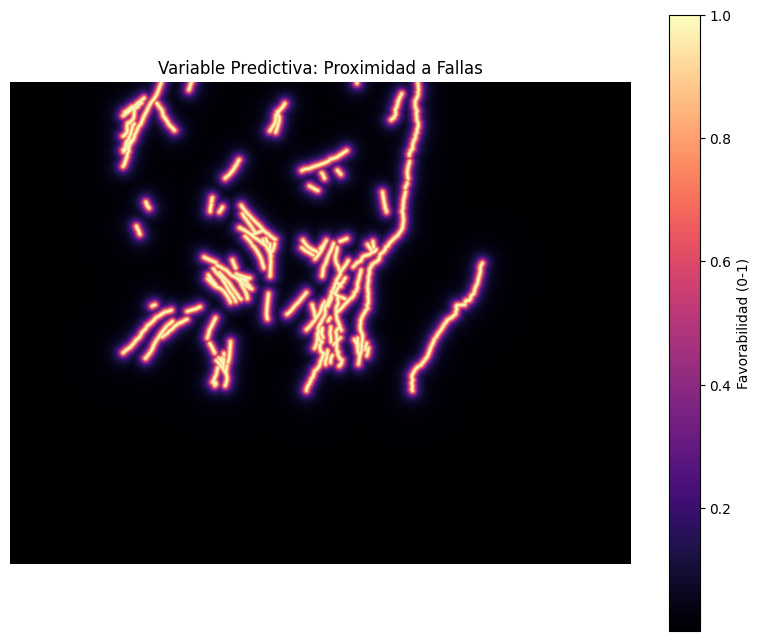

In [9]:
import geopandas as gpd
from rasterio import features
from scipy.ndimage import distance_transform_edt
import rasterio
import numpy as np
import matplotlib.pyplot as plt

#Rutas geol
shp_fallas = '/content/drive/MyDrive/Proyectoprospectivo/Data/GEOL/GB_FALLA_L.shp'
tif_ref = '/content/drive/MyDrive/Proyectoprospectivo/Data/raster/Mapa_Alteracion_FINAL_Coloreado.tif'

print("Construyendo Variable Estructural Real...")

# CARGAR FALLAS
gdf = gpd.read_file(shp_fallas)
print(f"   Fallas originales: {len(gdf)}")

# LEER REFERENCIA DEL SATÉLITE (Para copiar su grilla)
with rasterio.open(tif_ref) as src:
    meta = src.meta.copy()
    height, width = src.shape
    transform = src.transform
    # Importante: Obtener el CRS del satélite para igualar las fallas
    raster_crs = src.crs

# REPROYECTAR FALLAS (La clave del éxito)
# Convertimos de EPSG:31994 al sistema del satélite
gdf_proj = gdf.to_crs(raster_crs)
print(f"   Reproyectado a: {raster_crs}")

# RASTERIZAR (Vectores -> Píxeles)
# Quemamos las líneas en una matriz vacía
print("   Rasterizando líneas...")
shapes = ((geom, 1) for geom in gdf_proj.geometry)
burned = features.rasterize(shapes=shapes, fill=0, out_shape=(height, width), transform=transform)

# CALCULAR DISTANCIA (Euclidiana)
# Calculamos la distancia de cada píxel al "1" (falla) más cercano
# distance_transform_edt mide distancia a Ceros, así que invertimos (1-burned)
dist_pixels = distance_transform_edt(1 - burned)

# Convertir a metros (aprox 30m por pixel ASTER)
dist_meters = dist_pixels * 30

# VARIABLE FUZZY (Lógica)
# Hipótesis: < xxxx km es bueno. Función sigmoide.
fuzzy_structure = 1 / (1 + (dist_meters / 500)**2)

print(" Variable 'Proximidad a Fallas' lista.")

# VISUALIZACIÓN
plt.figure(figsize=(10, 8))
plt.imshow(fuzzy_structure, cmap='magma')
plt.colorbar(label='Favorabilidad (0-1)')
plt.title("Variable Predictiva: Proximidad a Fallas")
plt.axis('off')
plt.show()

Procesando Variable de Litología (Roca Huésped)...


/usr/local/lib/python3.12/dist-packages/rasterio/features.py:336: ShapeSkipWarning: Invalid or empty shape None at index 395 will not be rasterized.
  warnings.warn(


 Variable Litológica Creada.


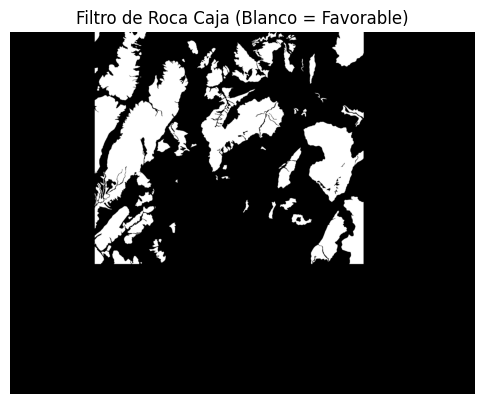

In [10]:
# VARIABLE LITOLÓGICA (ROCA CAJA)
print("Procesando Variable de Litología (Roca Huésped)...")

# Cargar el mapa geológico
shp_geol = '/content/drive/MyDrive/Proyectoprospectivo/Data/GEOL/GB_UNIDAD_GEO_P.shp'
gdf_geol = gpd.read_file(shp_geol)

# Filtrar Rocas Favorables (Intrusivos y Volcánicos)
# Definimos qué palabras clave buscamos en la descripción
# "K" Cretácico, "J" Jurásico
keywords = ['Intrusivo', 'Volcánico', 'Pórfido', 'Diorita', 'Granito', 'Andesita', 'Cretácico', 'Jurásico']
pattern_geol = '|'.join(keywords)

# Creamos columna binaria: 1 = Roca Dura/Favorable, 0 = Cobertura/Aluvial
gdf_geol['Es_Favorable'] = gdf_geol['NOMBRE'].str.contains(pattern_geol, case=False, na=False).astype(int)
gdf_geol['Es_Favorable'] = gdf_geol['Es_Favorable'].fillna(0) # Rellenar vacíos con 0

# Reproyectar y Rasterizar
gdf_geol_proj = gdf_geol.to_crs(raster_crs)

# 1 o 0 en el mapa
shapes_geol = ((geom, value) for geom, value in zip(gdf_geol_proj.geometry, gdf_geol_proj['Es_Favorable']))
litho_grid = features.rasterize(shapes=shapes_geol, fill=0, out_shape=(height, width), transform=transform)

# Aplanar para el modelo
flat_litho = litho_grid.flatten()

print(" Variable Litológica Creada.")

# VISUALIZACIÓN RÁPIDA
plt.figure(figsize=(6, 6))
plt.imshow(litho_grid, cmap='gray')
plt.title("Filtro de Roca Caja (Blanco = Favorable)")
plt.axis('off')
plt.show()

 Procesando Contactos Intrusivos...
   Total líneas de contacto: 2452
   Contactos Intrusivos seleccionados: 617
 Variable 'Proximidad a Contactos' creada.


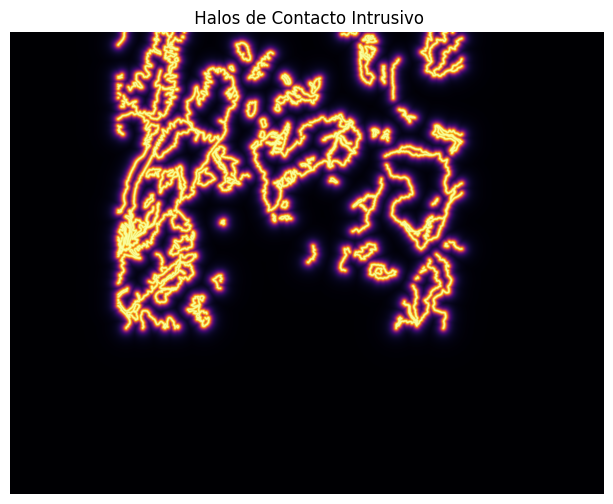

In [11]:
from scipy.ndimage import distance_transform_edt

# VARIABLE DE CONTACTOS INTRUSIVOS
print(" Procesando Contactos Intrusivos...")

shp_contactos = '/content/drive/MyDrive/Proyectoprospectivo/Data/GEOL/GB_CONTACTO_L.shp'
gdf_cont = gpd.read_file(shp_contactos)

# FILTRAR SOLO CONTACTOS MAGMÁTICOS
# columna 'SUBTIPO_DE' tiene 'Contacto Intrusivo'
# Filtramos para ignorar los estratigráficos
gdf_intrusivos = gdf_cont[gdf_cont['SUBTIPO_DE'].str.contains('Intrusivo', case=False, na=False)]

print(f"   Total líneas de contacto: {len(gdf_cont)}")
print(f"   Contactos Intrusivos seleccionados: {len(gdf_intrusivos)}")

# REPROYECTAR Y RASTERIZAR
gdf_cont_proj = gdf_intrusivos.to_crs(raster_crs)

# RASTERIZACION
shapes_cont = ((geom, 1) for geom in gdf_cont_proj.geometry)
burned_cont = features.rasterize(shapes=shapes_cont, fill=0, out_shape=(height, width), transform=transform)

# CALCULAR DISTANCIA EUCLIDIANA
# Calculamos distancia al contacto más cercano
dist_pixels_cont = distance_transform_edt(1 - burned_cont)
dist_meters_cont = dist_pixels_cont * 30

# 4. VARIABLE FUZZY
# Los "Halos" de mineralización suelen estar muy cerca del contacto (400-600m; lo dejamos en 400)
fuzzy_contactos = 1 / (1 + (dist_meters_cont / 400)**2)
flat_contactos = fuzzy_contactos.flatten()

print(" Variable 'Proximidad a Contactos' creada.")

# VISUALIZACIÓN
plt.figure(figsize=(8, 6))
plt.imshow(fuzzy_contactos, cmap='inferno')
plt.title(" Halos de Contacto Intrusivo")
plt.axis('off')
plt.show()

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import geopandas as gpd
from rasterio import features
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ruta ubicacion minas (carta 2009)
shp_minas = '/content/drive/MyDrive/Proyectoprospectivo/Data/GEOL/RMM_YACIMIENTO.shp'

print("ENTRENAMIENTO (OPTIMIZADO)...")

# PREPARAR LOS TARGETS (MINAS)
print("1. Procesando Yacimientos Conocidos...")
gdf_minas = gpd.read_file(shp_minas)

# Filtro (Cu, Au, Fe) - OJO: Puedes quitar 'Fe' si quieres más precisión de Cobre
target_metals = ['Cu', 'Au', 'Fe', 'Cobre', 'Oro', 'Hierro']
pattern = '|'.join(target_metals)
gdf_targets = gdf_minas[gdf_minas['d_ASS_MENA'].str.contains(pattern, case=False, na=False)].copy()

print(f"   Minas seleccionadas: {len(gdf_targets)}")

# CORRECCION Y BUFFER (Ajustado a 300m para mayor precisión)
gdf_utm = gdf_targets.to_crs(epsg=32719)
gdf_utm['geometry'] = gdf_utm.geometry.buffer(300)

# Volvemos al sistema del satélite
gdf_targets_final = gdf_utm.to_crs(raster_crs)

# Rasterizar Targets
shapes_minas = ((geom, 1) for geom in gdf_targets_final.geometry)
target_grid = features.rasterize(shapes=shapes_minas, fill=0, out_shape=(height, width), transform=transform)

# CONSOLIDAR EL DATASET DE ENTRENAMIENTO
print("2. Creando Tabla de Entrenamiento (X, y)...")

flat_alteration = alteration_data.flatten()
flat_structure = fuzzy_structure.flatten()
flat_target = target_grid.flatten()

# Limpieza
mask_valid = (flat_alteration > 0) & (~np.isnan(flat_alteration))

df_train = pd.DataFrame({
    'Alteracion_ASTER':    flat_alteration[mask_valid],
    'Distancia_Fallas':    flat_structure[mask_valid],
    'Litologia_Roca':      flat_litho[mask_valid],
    'Distancia_Contactos': flat_contactos[mask_valid],
    'Es_Mina':             flat_target[mask_valid]
})

print(f"   Dataset Total Original: {len(df_train)} muestras.")

#  BALANCEO DE DATOS (Vital para Random Forest)# ==============================================================================
print(" Balanceando Dataset (Estrategia 1:10)...")

# Separamos las minas (que son poquitas) del estéril (que es mucho)
df_minas_data = df_train[df_train['Es_Mina'] == 1]
df_esteril_data = df_train[df_train['Es_Mina'] == 0]

# Tomamos una muestra del estéril
# Si tenemos 5.000 píxeles de mina, tomaremos 50.000 de estéril (Ratio 1:10)
# Esto le da al modelo suficientes ejemplos de "qué NO es mina", pero sin ahogarlo.
n_muestras_esteril = len(df_minas_data) * 10
df_esteril_sample = df_esteril_data.sample(n=n_muestras_esteril, random_state=42)

# Juntamos todo en el dataframe final
df_final = pd.concat([df_minas_data, df_esteril_sample])

print(f"   Dataset Balanceado para Entrenar: {len(df_final)} muestras.")
print(f"   (Minas: {len(df_minas_data)} | Estéril: {len(df_esteril_sample)})")
# =============================================================================================================================

from sklearn.model_selection import RandomizedSearchCV

# ENTRENAMIENTO Y OPTIMIZACIÓN (TUNING)
print("3. Optimizando Hiperparámetros del Modelo...")

# Definimos las variables X e y usando el dataset balanceado
X = df_final[['Alteracion_ASTER', 'Distancia_Fallas', 'Litologia_Roca', 'Distancia_Contactos']]
y = df_final['Es_Mina']

# Split de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# OPTIMIZACIÓN

# Definimos la "Red" de parámetros a probar
# Probará combinaciones de estos valores
param_grid = {
    'n_estimators': [100, 200, 300],         # Número de árboles (más es mejor, pero más lento)
    'max_depth': [10, 20, 30, None],         # Profundidad (evita que memorice los datos)
    'min_samples_split': [2, 5, 10],         # Mínimo de datos para dividir una rama
    'min_samples_leaf': [1, 2, 4],           # Mínimo de datos en una hoja final
    'max_features': ['sqrt', 'log2']         # Cómo selecciona las variables
}

# Configuramos el Buscador (RandomizedSearchCV)
rf_base = RandomForestClassifier(class_weight='balanced', random_state=42)

rf_random = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_grid,
    n_iter=20,          # Probará 20 combinaciones aleatorias (Rápido y efectivo)
    cv=3,               # Validación Cruzada de 3 pliegues (Para estar seguros)
    verbose=1,          # Irá mostrando el progreso
    random_state=42,
    n_jobs=-1,          # Usa todos los núcleos de CPU
    scoring='roc_auc'   # Optimiza para encontrar "Agujas en el pajar" (Minas)
)

# Entrenamos buscando el mejor modelo
print(" Buscando la mejor configuración (esto tomará unos segundos)...")
rf_random.fit(X_train, y_train)

# Resultados
print(f" Mejores Parámetros Encontrados: {rf_random.best_params_}")

# Guardamos el modelo ganador en la variable 'rf_model'
rf_model = rf_random.best_estimator_

print(" Modelo Optimizado Entrenado.")

ENTRENAMIENTO (OPTIMIZADO)...
1. Procesando Yacimientos Conocidos...
   Minas seleccionadas: 85
2. Creando Tabla de Entrenamiento (X, y)...
   Dataset Total Original: 4146369 muestras.
 Balanceando Dataset (Estrategia 1:10)...
   Dataset Balanceado para Entrenar: 207702 muestras.
   (Minas: 18882 | Estéril: 188820)
3. Optimizando Hiperparámetros del Modelo...
 Buscando la mejor configuración (esto tomará unos segundos)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
 Mejores Parámetros Encontrados: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None}
 Modelo Optimizado Entrenado.


Generando Resultados Finales con Modelo Optimizado...
 REPORTE DE CLASIFICACIÓN (SET DE PRUEBA)
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     56646
           1       0.62      0.71      0.66      5665

    accuracy                           0.93     62311
   macro avg       0.80      0.83      0.81     62311
weighted avg       0.94      0.93      0.94     62311

 Pintando Mapa de Prospectividad...

--- IMPORTANCIA DE VARIABLES (¿Qué controla la mineralización?) ---
1. ASTER (Arcillas):     13.1%
2. Fallas Regionales:    41.4%
3. Litología (Roca):     3.1%
4. Contactos Intrusivos: 42.4%


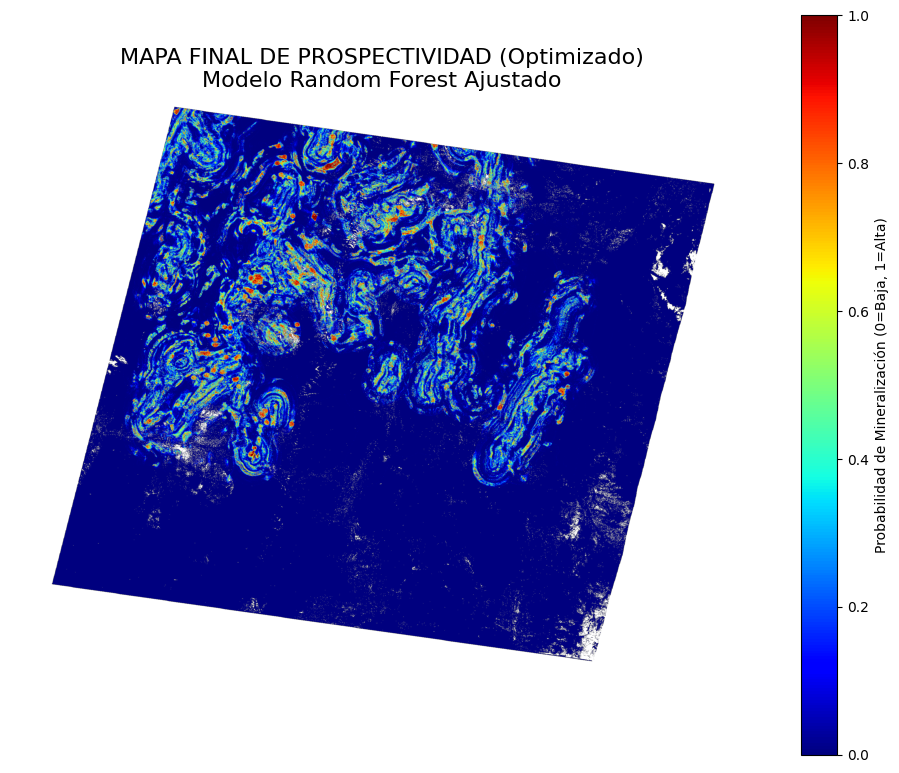

Guardando archivo final en: /content/drive/MyDrive/Proyectoprospectivo/Data/raster/Mapa_Prospectividad_OPTIMIZADO.tif
PROYECTO FINALIZADO


In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
from osgeo import gdal

print("Generando Resultados Finales con Modelo Optimizado...")

# EVALUACIÓN DE CALIDAD
# Vemos qué tan bueno es el modelo usando el set de prueba que guardamos (X_test)
print(" REPORTE DE CLASIFICACIÓN (SET DE PRUEBA)")
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

# GENERAR EL MAPA COMPLETO
print(" Pintando Mapa de Prospectividad...")
# Preparamos el lienzo vacío (lleno de NaNs)
prob_map_flat = np.full(flat_alteration.shape, np.nan)

# Usamos 'df_train' (que tiene los 4 millones de píxeles originales) para predecir todo el territorio
# Mismas columnas de entrenamiento
X_completo = df_train[['Alteracion_ASTER', 'Distancia_Fallas', 'Litologia_Roca', 'Distancia_Contactos']]

# Predecimos la probabilidad (0 a 1) de que sea mina
probs = rf_model.predict_proba(X_completo)[:, 1]

# Rellenamos el mapa solo en los píxeles válidos
prob_map_flat[mask_valid] = probs
prob_map_2d = prob_map_flat.reshape((height, width))

# VISUALIZACIÓN
plt.figure(figsize=(12, 12))

# Mapa de Calor
im = plt.imshow(prob_map_2d, cmap='jet', vmin=0, vmax=1)
plt.colorbar(im, label='Probabilidad de Mineralización (0=Baja, 1=Alta)', shrink=0.8)

# Títulos
plt.title("MAPA FINAL DE PROSPECTIVIDAD (Optimizado)\nModelo Random Forest Ajustado", fontsize=16)
plt.axis('off') # Quitar ejes de píxeles para limpieza visual

# Mostrar Importancia de Variables
importances = rf_model.feature_importances_
print("\n--- IMPORTANCIA DE VARIABLES (¿Qué controla la mineralización?) ---")
print(f"1. ASTER (Arcillas):     {importances[0]*100:.1f}%")
print(f"2. Fallas Regionales:    {importances[1]*100:.1f}%")
print(f"3. Litología (Roca):     {importances[2]*100:.1f}%")
print(f"4. Contactos Intrusivos: {importances[3]*100:.1f}%")
plt.show()

# 4. GUARDAR RESULTADO (GEOTIFF)
output_path = '/content/drive/MyDrive/Proyectoprospectivo/Data/raster/Mapa_Prospectividad_OPTIMIZADO.tif'
print(f"Guardando archivo final en: {output_path}")

driver = gdal.GetDriverByName('GTiff')
out_ds = driver.Create(output_path, width, height, 1, gdal.GDT_Float32)
out_ds.SetGeoTransform(transform.to_gdal())
out_ds.SetProjection(raster_crs.to_wkt())
out_ds.GetRasterBand(1).WriteArray(prob_map_2d)
out_ds.GetRasterBand(1).SetNoDataValue(np.nan)
out_ds = None # Cerrar y guardar

print("PROYECTO FINALIZADO")

 Generando Productos Finales (Versión Corregida)...


/tmp/ipython-input-3579030171.py:22: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  plt.scatter(gdf_targets_final.geometry.centroid.x, gdf_targets_final.geometry.centroid.y,


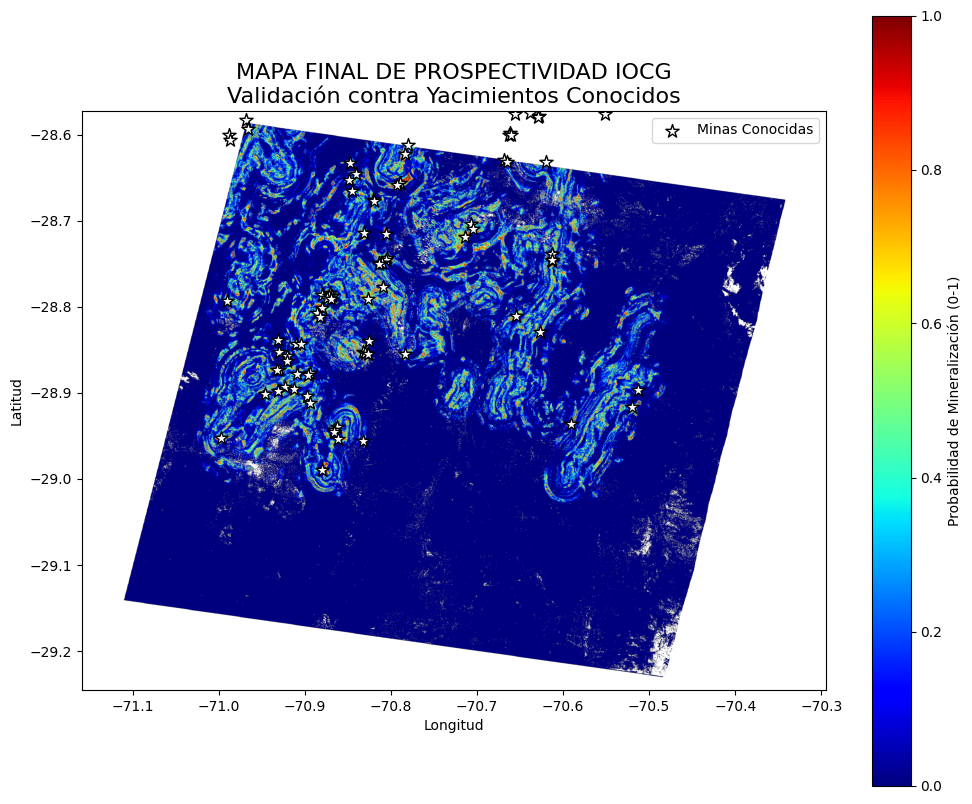


Guardando archivo entregable en: /content/drive/MyDrive/Proyectoprospectivo/Data/raster/Mapa_Prospectividad_FINAL.tif
PROYECTO COMPLETADO EXITOSAMENTE
1. Las estrellas blancas deberían caer en las zonas rojas


In [15]:
import matplotlib.pyplot as plt
from osgeo import gdal

print(" Generando Productos Finales (Versión Corregida)...")

# VISUALIZACIÓN DE CONTROL DE CALIDAD
plt.figure(figsize=(12, 10))

# El Mapa de Calor (Probabilidad)
extent = [
    meta['transform'][2], # Oeste
    meta['transform'][2] + meta['transform'][0] * width, # Este
    meta['transform'][5] + meta['transform'][4] * height, # Sur
    meta['transform'][5] # Norte
]

im = plt.imshow(prob_map_2d, cmap='jet', vmin=0, vmax=1, extent=extent, origin='upper')
plt.colorbar(im, label='Probabilidad de Mineralización (0-1)')

# Superponer las Minas (CORRECCIÓN: Usamos el Centroide)
# Como 'gdf_targets_final' son polígonos (buffers), extraemos su punto central
plt.scatter(gdf_targets_final.geometry.centroid.x, gdf_targets_final.geometry.centroid.y,
            c='white', edgecolors='black', s=100, marker='*', label='Minas Conocidas')

plt.title(f"MAPA FINAL DE PROSPECTIVIDAD IOCG\nValidación contra Yacimientos Conocidos", fontsize=16)
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.legend(loc='upper right')
plt.grid(False)
plt.show()

# EXPORTACIÓN DEL GEOTIFF FINAL
output_final_path = '/content/drive/MyDrive/Proyectoprospectivo/Data/raster/Mapa_Prospectividad_FINAL.tif'

print(f"\nGuardando archivo entregable en: {output_final_path}")

# Configuración para guardar
driver = gdal.GetDriverByName('GTiff')
out_ds = driver.Create(output_final_path, width, height, 1, gdal.GDT_Float32)

# Copiar la georreferencia original del ASTER
out_ds.SetGeoTransform(transform.to_gdal())
out_ds.SetProjection(raster_crs.to_wkt())

# Escribir la matriz de probabilidad
out_ds.GetRasterBand(1).WriteArray(prob_map_2d)
out_ds.GetRasterBand(1).SetNoDataValue(np.nan)

out_ds.FlushCache()
out_ds = None

print("PROYECTO COMPLETADO EXITOSAMENTE")
print("1. Las estrellas blancas deberían caer en las zonas rojas")

VALIDACIÓN...
1. Reconstruyendo coordenadas espaciales...
2. Generando 5 'Distritos Virtuales' (Spatial Clusters)...


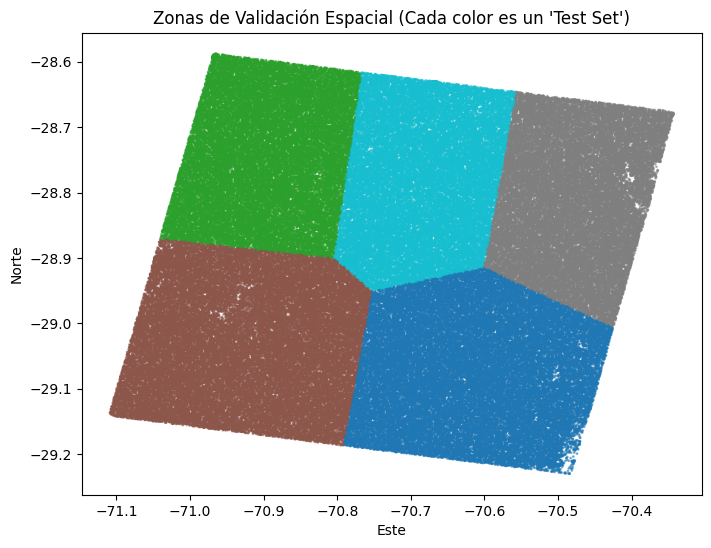

3. Ejecutando Spatial Cross-Validation...

 RESULTADOS DE LA AUDITORÍA ESPACIAL
Scores por Bloque: [0.84462072 0.98076594 0.54474324 0.57490187 0.8381185 ]
 Promedio ROC-AUC Espacial: 0.757

INTERPRETACIÓN:
 EXCELENTE: Modelo es capaz de predecir.


In [16]:
from sklearn.model_selection import cross_val_score, GroupKFold
from sklearn.cluster import KMeans

print("VALIDACIÓN...")

# RECUPERAR COORDENADAS PARA EL DATASET BALANCEADO
# Necesitamos saber DÓNDE está cada punto para agruparlos
print("1. Reconstruyendo coordenadas espaciales...")

# Generamos las grillas de coordenadas X e Y para todo el mapa
rows, cols = np.indices((height, width))
# Transformamos píxeles a coordenadas reales (UTM) usando la georreferencia
xs, ys = rasterio.transform.xy(transform, rows, cols)
# Aplanamos
flat_x = np.array(xs).flatten() ### esto puede ser pesado en memoria
flat_y = np.array(ys).flatten() # Si falla por RAM, hay formas más ligeras

# Filtramos usando la misma máscara de datos válidos
x_valid = flat_x[mask_valid]
y_valid = flat_y[mask_valid]

# Ahora cruzamos esto con nuestro dataframe balanceado (df_final)
# Como df_final es una muestra aleatoria, necesitamos sus índices originales para recuperar su X,Y
indices_final = df_final.index
dataset_x = x_valid[indices_final]
dataset_y = y_valid[indices_final]

# CREAR BLOQUES ESPACIALES (CLUSTERS)
print("2. Generando 5 'Distritos Virtuales' (Spatial Clusters)...")
coords = np.column_stack((dataset_x, dataset_y))

# Usamos KMeans para dividir los datos en 5 zonas geográficas distintas
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
spatial_groups = kmeans.fit_predict(coords)

# Visualizar los bloques
plt.figure(figsize=(8, 6))
plt.scatter(dataset_x, dataset_y, c=spatial_groups, cmap='tab10', s=1, alpha=0.5)
plt.title("Zonas de Validación Espacial (Cada color es un 'Test Set')")
plt.xlabel("Este"); plt.ylabel("Norte")
plt.show()

# VALIDACIÓN CRUZADA ESPACIAL
print("3. Ejecutando Spatial Cross-Validation...")

# Configuramos el esquema: GroupKFold respeta los grupos (no mezcla datos de un grupo en train y test)
gkf = GroupKFold(n_splits=5)

# Variables de entrenamiento actuales
X_val = df_final[['Alteracion_ASTER', 'Distancia_Fallas', 'Litologia_Roca', 'Distancia_Contactos']]
y_val = df_final['Es_Mina']

# Evaluamos
spatial_scores = cross_val_score(rf_model, X_val, y_val, groups=spatial_groups, cv=gkf, scoring='roc_auc')

print("\n" + "="*40)
print(" RESULTADOS DE LA AUDITORÍA ESPACIAL")
print("="*40)
print(f"Scores por Bloque: {spatial_scores}")
print(f" Promedio ROC-AUC Espacial: {np.mean(spatial_scores):.3f}")
print("="*40)

# INTERPRETACIÓN
print("\nINTERPRETACIÓN:")
if np.mean(spatial_scores) > 0.75:
    print(" EXCELENTE: Modelo es capaz de predecir.")
elif np.mean(spatial_scores) > 0.60:
    print(" ACEPTABLE: El modelo generaliza, pero sufre al salir de zona conocida.")
else:
    print(" RIESGO DE OVERFITTING: El modelo memorizó las minas locales y falla en zonas nuevas.")

In [17]:
import numpy as np

print("CALCULANDO ÁREA REAL DE EXPLORACIÓN...")

# Contar píxeles válidos (que no sean NaN ni cero)
# Usamos la máscara creada en el entrenamiento
num_pixeles_validos = np.sum(mask_valid)

# Tamaño de un píxel ASTER SWIR (30m x 30m)
area_pixel_m2 = 30 * 30  # 900 m2

# Cálculo Total
area_total_m2 = num_pixeles_validos * area_pixel_m2
area_total_km2 = area_total_m2 / 1_000_000 # Convertir m2 a km2

print(f" Píxeles con Información Geológica: {num_pixeles_validos:,}")
print(f" Área Real Efectiva: {area_total_km2:.2f} km²")


CALCULANDO ÁREA REAL DE EXPLORACIÓN...
 Píxeles con Información Geológica: 4,146,369
 Área Real Efectiva: 3731.73 km²


60x60km